In [14]:
import warnings
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_openml,load_iris,fetch_california_housing
from sklearn.feature_selection import mutual_info_regression, f_regression, RFE, SelectFromModel, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
RepeatedStratifiedKFold, 
cross_val_score, 
train_test_split, 
GridSearchCV,
cross_val_predict, 
learning_curve, 
validation_curve)
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error,zero_one_loss, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from os.path import join as pjoin
from mlxtend.evaluate import bias_variance_decomp
#sharper plots
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)
from PIL import Image
import random
warnings.filterwarnings("ignore")
from shutil import copyfile
from sklearn.svm import SVC

In [2]:
data_path = r"C:\Users\Acer\Desktop\spbu_ml_2025\data\PetImages"
cat_folder= os.path.join(data_path,"Cat")
cat_img= os.listdir(cat_folder)
print(len(cat_img))
print(cat_img[:5])
dog_folder= os.path.join(data_path,"Dog")
dog_img= os.listdir(cat_folder)
print(len(dog_img))
print(dog_img[:5])

12499
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']
12499
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg']


In [3]:
def process_image(filename, size=64):
    with Image.open(filename) as img:
        # Convert to grayscale and resize
        img = img.convert('L').resize((size, size))
        
        # Convert to numpy array with channel dimension
        arr = np.array(img, dtype=np.uint8)[..., np.newaxis]
        return arr

In [4]:
random.seed(1234)
cats_path = cat_folder
image_shape = (64, 64)
rows, cols = 2, 4
n_samples = rows * cols

all_files = [f for f in os.listdir(cats_path ) 
                if f.lower().endswith(('.jpg', '.jpeg'))]
processed_cats = []
for filename in random.sample(all_files, 120):
    processed_cats.append(process_image(os.path.join(cats_path, filename)))
    
random.seed(1234)
dogs_path = dog_folder
image_shape = (64, 64)
rows, cols = 2, 4
n_samples = rows * cols

all_files = [f for f in os.listdir(dogs_path ) 
                if f.lower().endswith(('.jpg', '.jpeg'))]
processed_dogs = []
for filename in random.sample(all_files, 120):
    processed_dogs.append(process_image(os.path.join(dogs_path, filename)))

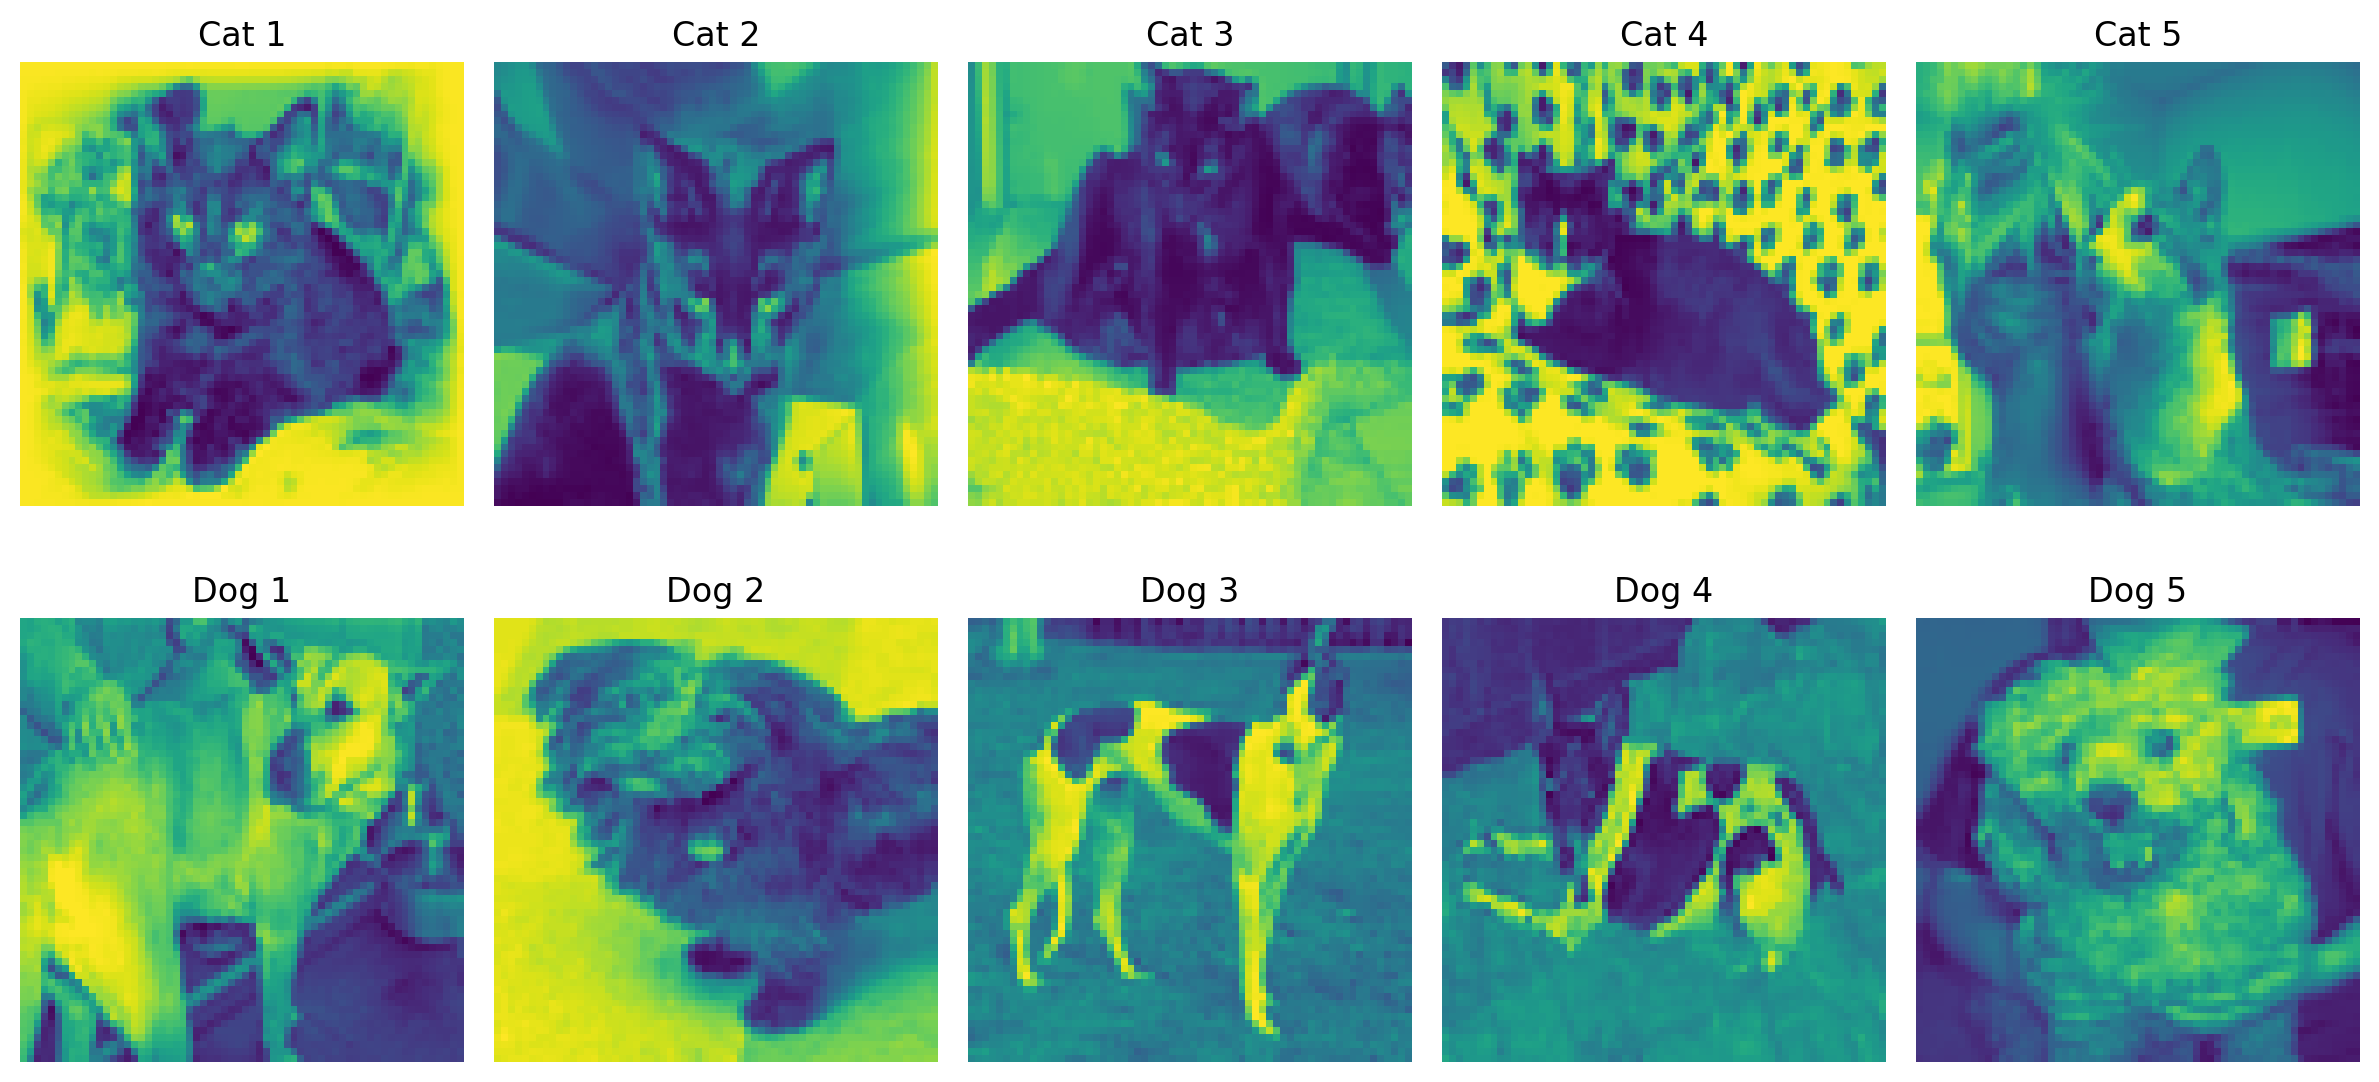

In [5]:
# Display 5 random cat images
random.seed(1234)
cat_files = [f for f in os.listdir(cats_path) if f.lower().endswith(('.jpg', '.jpeg'))]
cat_samples = random.sample(cat_files, 5)
processed_cats = [process_image(os.path.join(cats_path, filename)) for filename in cat_samples]

# Display 5 random dog images
random.seed(1234)
dog_files = [f for f in os.listdir(dogs_path) if f.lower().endswith(('.jpg', '.jpeg'))]
dog_samples = random.sample(dog_files, 5)
processed_dogs = [process_image(os.path.join(dogs_path, filename)) for filename in dog_samples]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Plot cat images
for i, ax in enumerate(axes[0, :]):
    ax.imshow(processed_cats[i])
    ax.axis('off')
    ax.set_title(f"Cat {i+1}")

# Plot dog images
for i, ax in enumerate(axes[1, :]):
    ax.imshow(processed_dogs[i])
    ax.axis('off')
    ax.set_title(f"Dog {i+1}")

plt.tight_layout()
plt.show()

In [6]:
# Размер изображений после сжатия
image_size = (64, 64)

# Функция загрузки изображений в numpy-массив
def load_images_from_folder(folder, label, n=12400):
    images = []
    labels = []
    filenames = sorted(os.listdir(folder))[:n]
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = Image.open(os.path.join(folder, filename)).convert("L")  # ЧБ
            img = img.resize(image_size)  # Уменьшаем размер
            img_array = np.array(img).flatten()  # В 1D массив
            images.append(img_array)
            labels.append(label)
    return images, labels

cat_images, cat_labels = load_images_from_folder(cat_folder, label=0)
dog_images, dog_labels = load_images_from_folder(dog_folder, label=1)

X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

print(f"Размер X: {X.shape}, Размер y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

print(f"Train: {X_train.shape}, Test: {X_test.shape}") 


Размер X: (24800, 4096), Размер y: (24800,)
Train: (19840, 4096), Test: (4960, 4096)


In [7]:
# Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Размер после PCA: {X_train_pca.shape}, {X_test_pca.shape}")


Размер после PCA: (19840, 413), (4960, 413)


In [8]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность knn: {accuracy:.4f}")


Точность knn: 0.5802


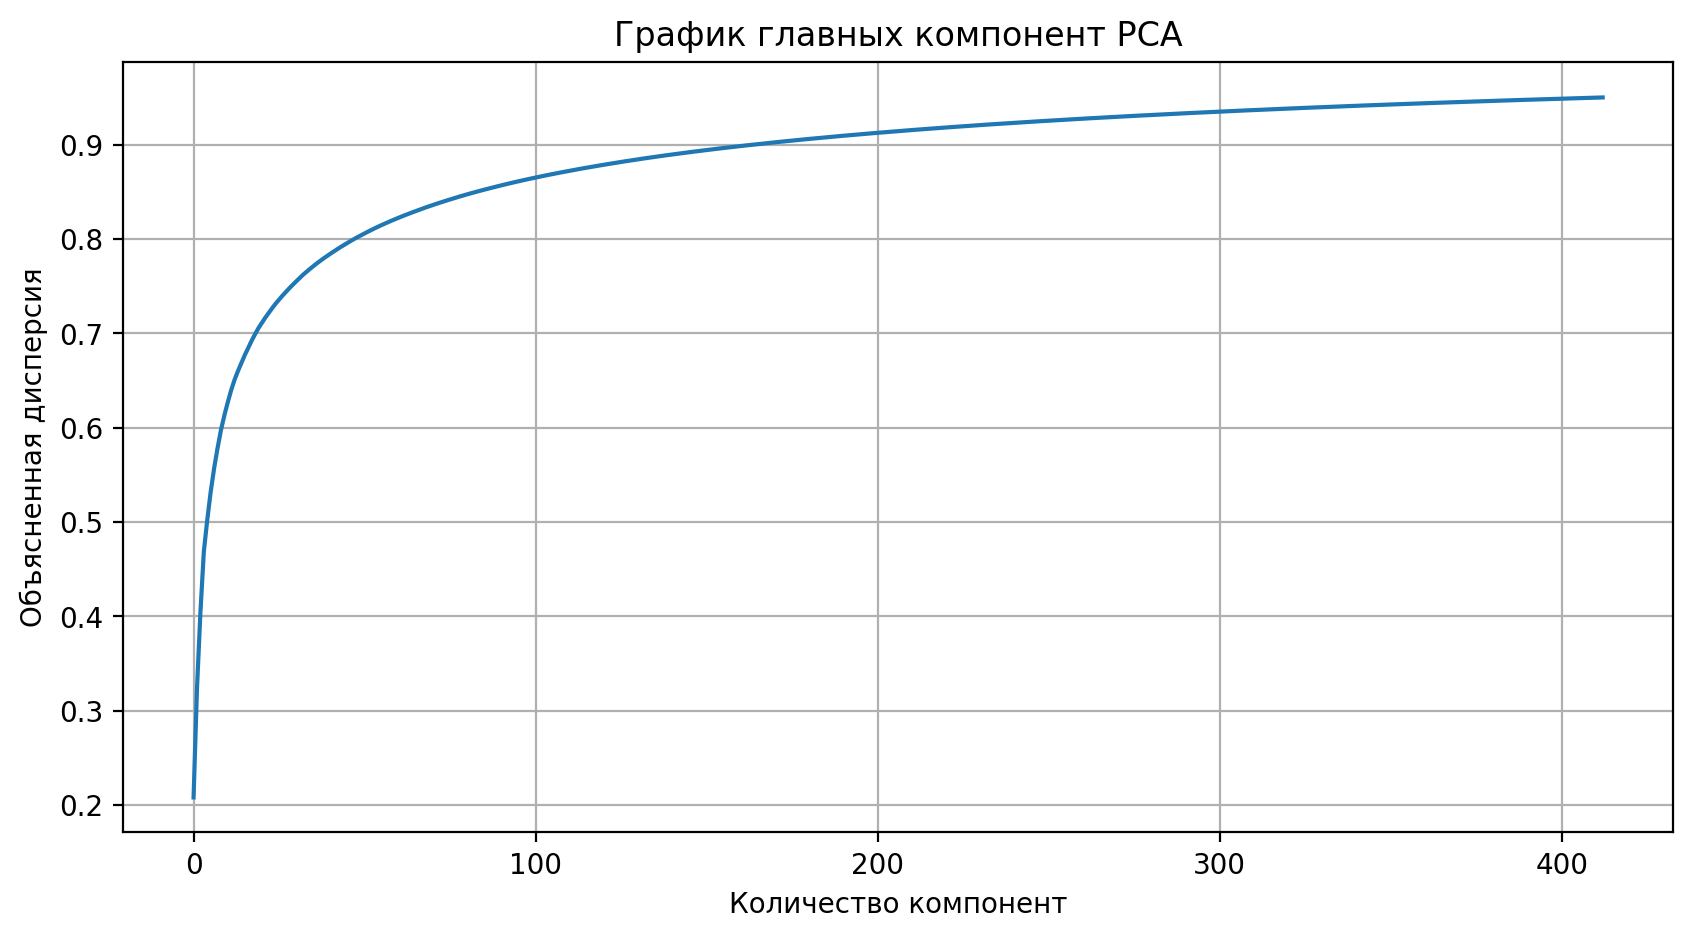

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Количество компонент")
plt.ylabel("Объясненная дисперсия")
plt.title("График главных компонент PCA")
plt.grid()
plt.show()


- Ответьте на вопрос: сколько компонент требуется для объяснения 90% дисперсии?
160  
При меньшем кол-ве изображений хватало 80 компанент

In [15]:
%%time


knn_pca = KNeighborsClassifier(n_neighbors=4, p=2, weights="distance")

knn_pca.fit(X_train_pca, y_train)


y_test_predicted_pca_knn = knn_pca.predict(X_test_pca)
print("KNN (PCA): Test Accuracy: ", accuracy_score(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Classification Report:")
print(classification_report(y_test, y_test_predicted_pca_knn))

print("\n")

KNN (PCA): Test Accuracy:  0.5760080645161291

KNN (PCA): Test Confusion Matrix:
[[1583  897]
 [1206 1274]]

KNN (PCA): Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60      2480
           1       0.59      0.51      0.55      2480

    accuracy                           0.58      4960
   macro avg       0.58      0.58      0.57      4960
weighted avg       0.58      0.58      0.57      4960



CPU times: total: 5.48 s
Wall time: 410 ms


In [16]:
%%time

forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train, y_train)

y_test_predicted_rf = forest_clf.predict(X_test)
print("Random Forest: Test Accuracy: ", accuracy_score(y_test, y_test_predicted_rf))

print("\nRandom Forest: Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nRandom Forest: Classification Report:")
print(classification_report(y_test, y_test_predicted_rf))

print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.6min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.1s


Random Forest: Test Accuracy:  0.6514112903225806

Random Forest: Test Confusion Matrix:
[[1749  731]
 [ 998 1482]]

Random Forest: Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67      2480
           1       0.67      0.60      0.63      2480

    accuracy                           0.65      4960
   macro avg       0.65      0.65      0.65      4960
weighted avg       0.65      0.65      0.65      4960



CPU times: total: 21min 29s
Wall time: 2min 27s


[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
forest = RandomForestClassifier(n_estimators=1000, max_depth=32, class_weight="balanced", oob_score=True, n_jobs=-1, verbose=0)

models = {"KNN": knn, "Random Forest": forest}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} (без PCA) Test Accuracy: {acc:.4f}")


KNN (без PCA) Test Accuracy: 0.5647
Random Forest (без PCA) Test Accuracy: 0.6504


In [18]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred_pca = model.predict(X_test_pca)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    print(f"{name} (с PCA) Test Accuracy: {acc_pca:.4f}")


KNN (с PCA) Test Accuracy: 0.5895
Random Forest (с PCA) Test Accuracy: 0.6310


PCA components: 5, Accuracy: 0.5514
PCA components: 10, Accuracy: 0.5661
PCA components: 15, Accuracy: 0.5891
PCA components: 20, Accuracy: 0.5909
PCA components: 25, Accuracy: 0.5931
PCA components: 30, Accuracy: 0.5847
PCA components: 35, Accuracy: 0.5931
PCA components: 40, Accuracy: 0.5966
PCA components: 45, Accuracy: 0.5917
PCA components: 50, Accuracy: 0.5988
PCA components: 55, Accuracy: 0.5913
PCA components: 60, Accuracy: 0.5879
PCA components: 65, Accuracy: 0.5897
PCA components: 70, Accuracy: 0.5933
PCA components: 75, Accuracy: 0.5950
PCA components: 80, Accuracy: 0.5923
PCA components: 85, Accuracy: 0.5893
PCA components: 90, Accuracy: 0.5899
PCA components: 95, Accuracy: 0.5891
PCA components: 100, Accuracy: 0.5873
PCA components: 105, Accuracy: 0.5895
PCA components: 110, Accuracy: 0.5877
PCA components: 115, Accuracy: 0.5907
PCA components: 120, Accuracy: 0.5929
PCA components: 125, Accuracy: 0.5897
PCA components: 130, Accuracy: 0.5897
PCA components: 135, Accuracy: 0

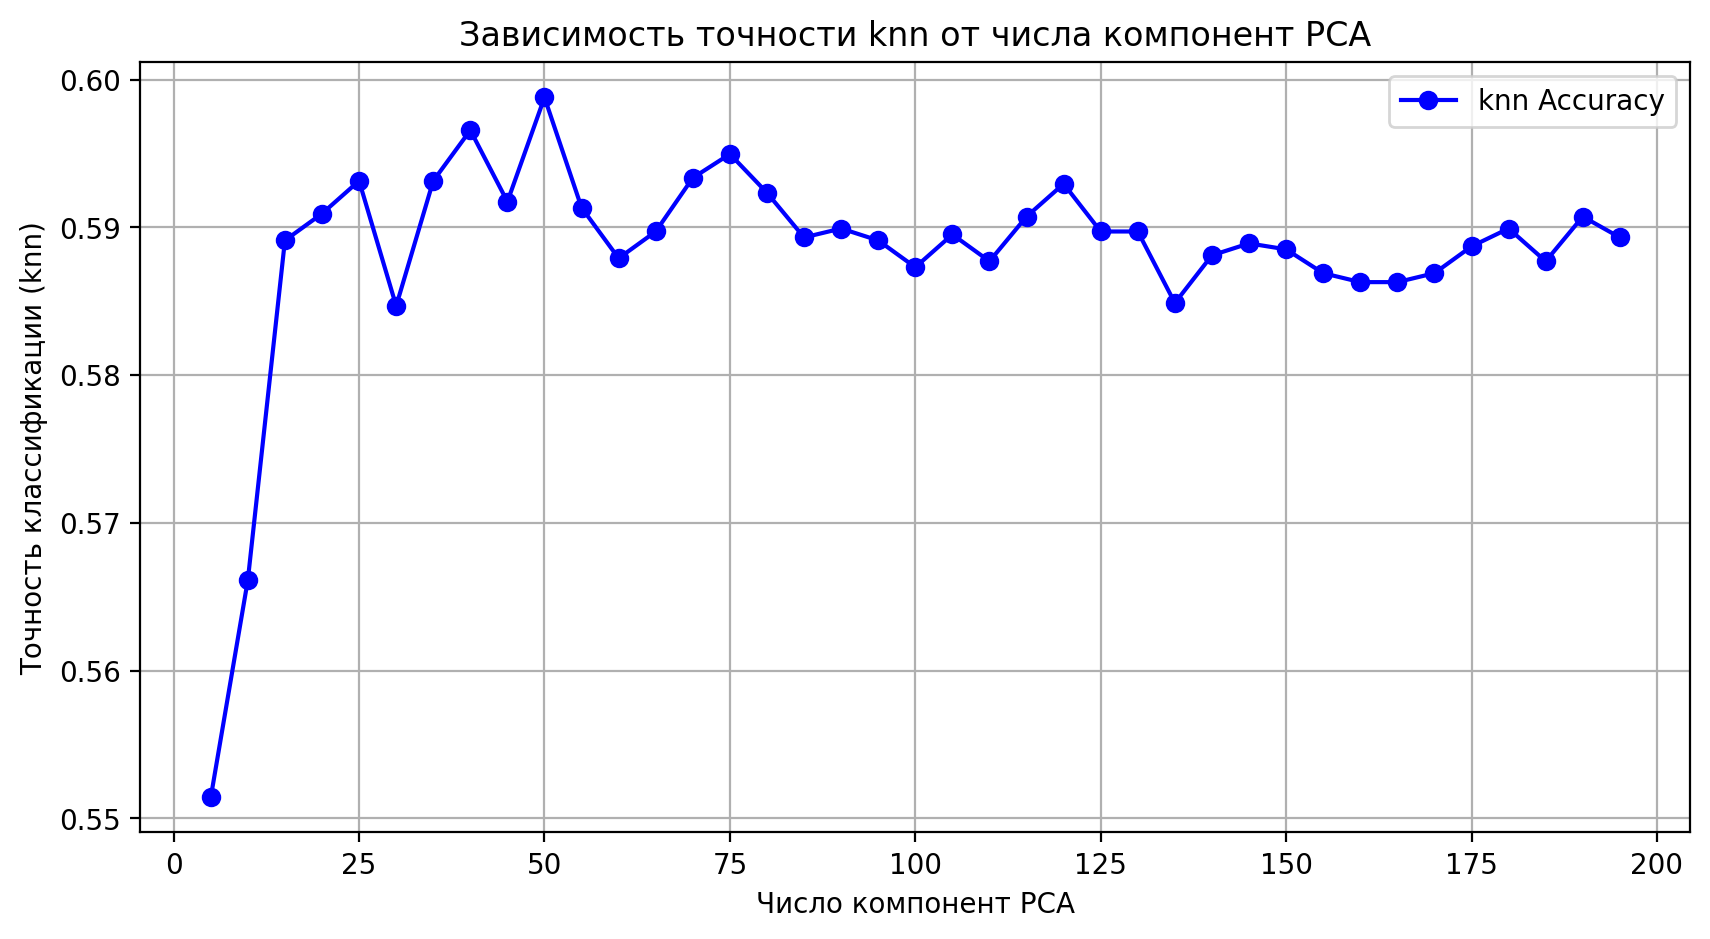

In [ ]:
n_components_list = np.arange(5, min(X_train.shape[1], 200), 5)

accuracy_scores = []

# Перебираем число компонент PCA
for n in n_components_list:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_pca, y_train)

    # Оцениваем точность на тестовой выборке
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

    print(f"PCA components: {n}, Accuracy: {accuracy:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(n_components_list, accuracy_scores, marker='o', linestyle='-', color='b', label="knn Accuracy")
plt.xlabel("Число компонент PCA")
plt.ylabel("Точность классификации (knn)")
plt.title("Зависимость точности knn от числа компонент PCA")
plt.legend()
plt.grid(True)
plt.show()


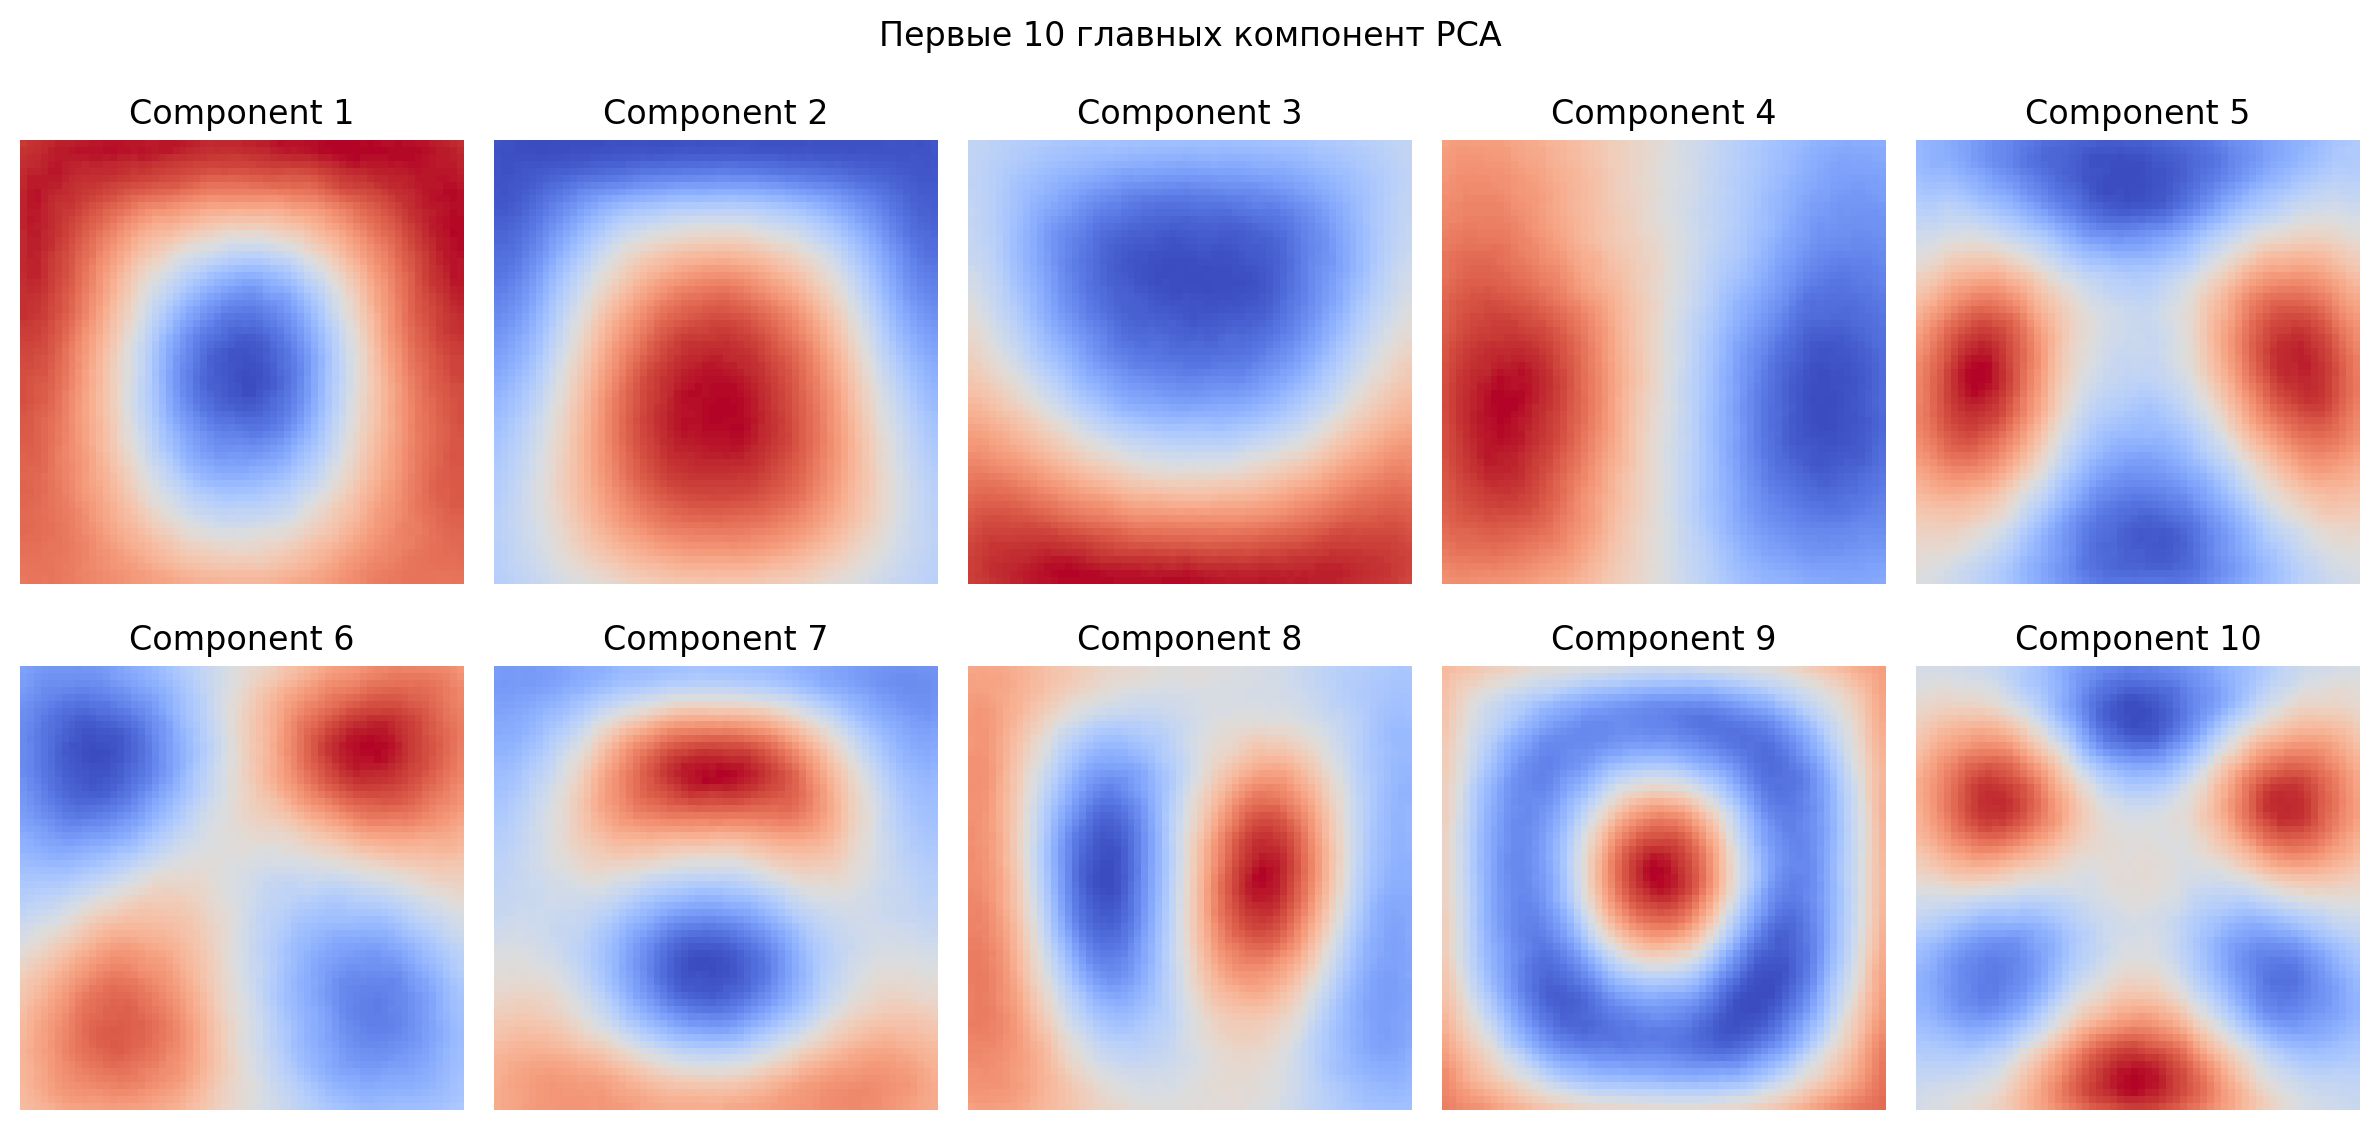

In [21]:
# Оптимальное число компонент
best_n_components = 50

pca = PCA(n_components=best_n_components)
X_train_pca = pca.fit_transform(X_train)

components = pca.components_[:10]  # Берем первые 10

img_shape = int(np.sqrt(components.shape[1]))

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    component_image = components[i].reshape((img_shape, img_shape))  # Преобразуем в 2D
    axes[i].imshow(component_image, cmap="coolwarm")  # Отображаем компоненту
    axes[i].set_title(f"Component {i+1}")
    axes[i].axis("off")

plt.suptitle("Первые 10 главных компонент PCA")
plt.tight_layout()
plt.show()
